In [1]:
import pickle
import numpy as np
import os
import shap

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
# IMPORTANT: SET RANDOM SEEDS FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED'] = str(420)
import random
random.seed(420)
np.random.seed(420)

In [3]:
#Select GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
### Load Model (For Efficiency Addative Normalization)
from tensorflow.keras.layers import (Input, Layer, Dense, Lambda, Reshape, Multiply)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf

import sys
sys.path.insert(0, '../../../../fastshap_tf/')
from utils import ShapleySampler, ResizeMask

P = 14*14
INPUT_SHAPE = (224,224,3)
value_model = ResNet50(
    include_top=False, weights='imagenet', 
    input_shape=INPUT_SHAPE, pooling='avg'
) 
D = 10

model_input = Input(shape=INPUT_SHAPE, dtype='float64', name='input')
S = ShapleySampler(P, paired_sampling=False, num_samples=1)(model_input)
S = Lambda(lambda x: tf.cast(x, tf.float32))(S)
S = Reshape((P,))(S)
S = ResizeMask(in_shape=INPUT_SHAPE, mask_size=P)(S)
xs = Multiply()([model_input, S])

net = value_model(xs)
out = Dense(D, activation='softmax')(net)

surrogate = Model(model_input, out)

# Get Checkpointed Model
weights_path = '../surrogate/20210515_01_11_10/value_weights.h5'
surrogate.load_weights(weights_path)

# Remove Masking Layer
surrogate = Sequential(   
    [l for l in surrogate.layers[-2:]]
)
surrogate.trainable = False


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [5]:
## Function to Reverse Image Transform
def restore_original_image_from_array(x, data_format='channels_last'):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x

In [6]:
### Load Shap Values

method = 'fastshap'
import pickle
import numpy as np
if method == 'deepshap':
    method_dir = os.path.join('../', method) 
else:
    method_dir = os.path.join('../', method, 'results') 

with open(os.path.join(method_dir, 'shap_values.pkl'), 'rb') as f:
    shap_values = pickle.load(f)

In [7]:
### Load Labels and Model Predictions

labels_path = '../images/labels.npy'
labels = np.load(labels_path, allow_pickle=True)

preds_path = '../images/predictions.npy'
preds = np.load(preds_path, allow_pickle=True)

images_dir = os.path.join('../', 'images')
images = np.load(os.path.join(images_dir, 'processed_images.npy'), allow_pickle=True)

In [8]:
### Select 10 Random Images + Transform
inds = np.random.choice(np.arange(1000), 18, replace=False)

labels = labels[inds]
preds = shap.links.logit(np.clip(preds[inds], 1e-7, 1-1e-7))
images = restore_original_image_from_array(images[inds])
shap_values = [sv[inds] for sv in shap_values]
null = shap.links.logit(surrogate.predict(np.zeros((1,*images[0].shape))))

In [9]:
### Apply Addative Normalization
normalize = True

def addative_normalization(shap_values, preds, null):
    shap_sum = [sv.reshape(sv.shape[0], -1).sum(1)/(16*16) for sv in shap_values]
    shap_sum = np.array(shap_sum).transpose()
    
    y = preds - null
    
    gap = (y - shap_sum).transpose()
    
    shap_values = [sv + (g.reshape(g.shape[0], 1, 1)/(14*14)) 
                   for sv, g in zip(shap_values, gap)]
    
    return shap_values

if normalize:
    shap_values = addative_normalization(shap_values, preds, null)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


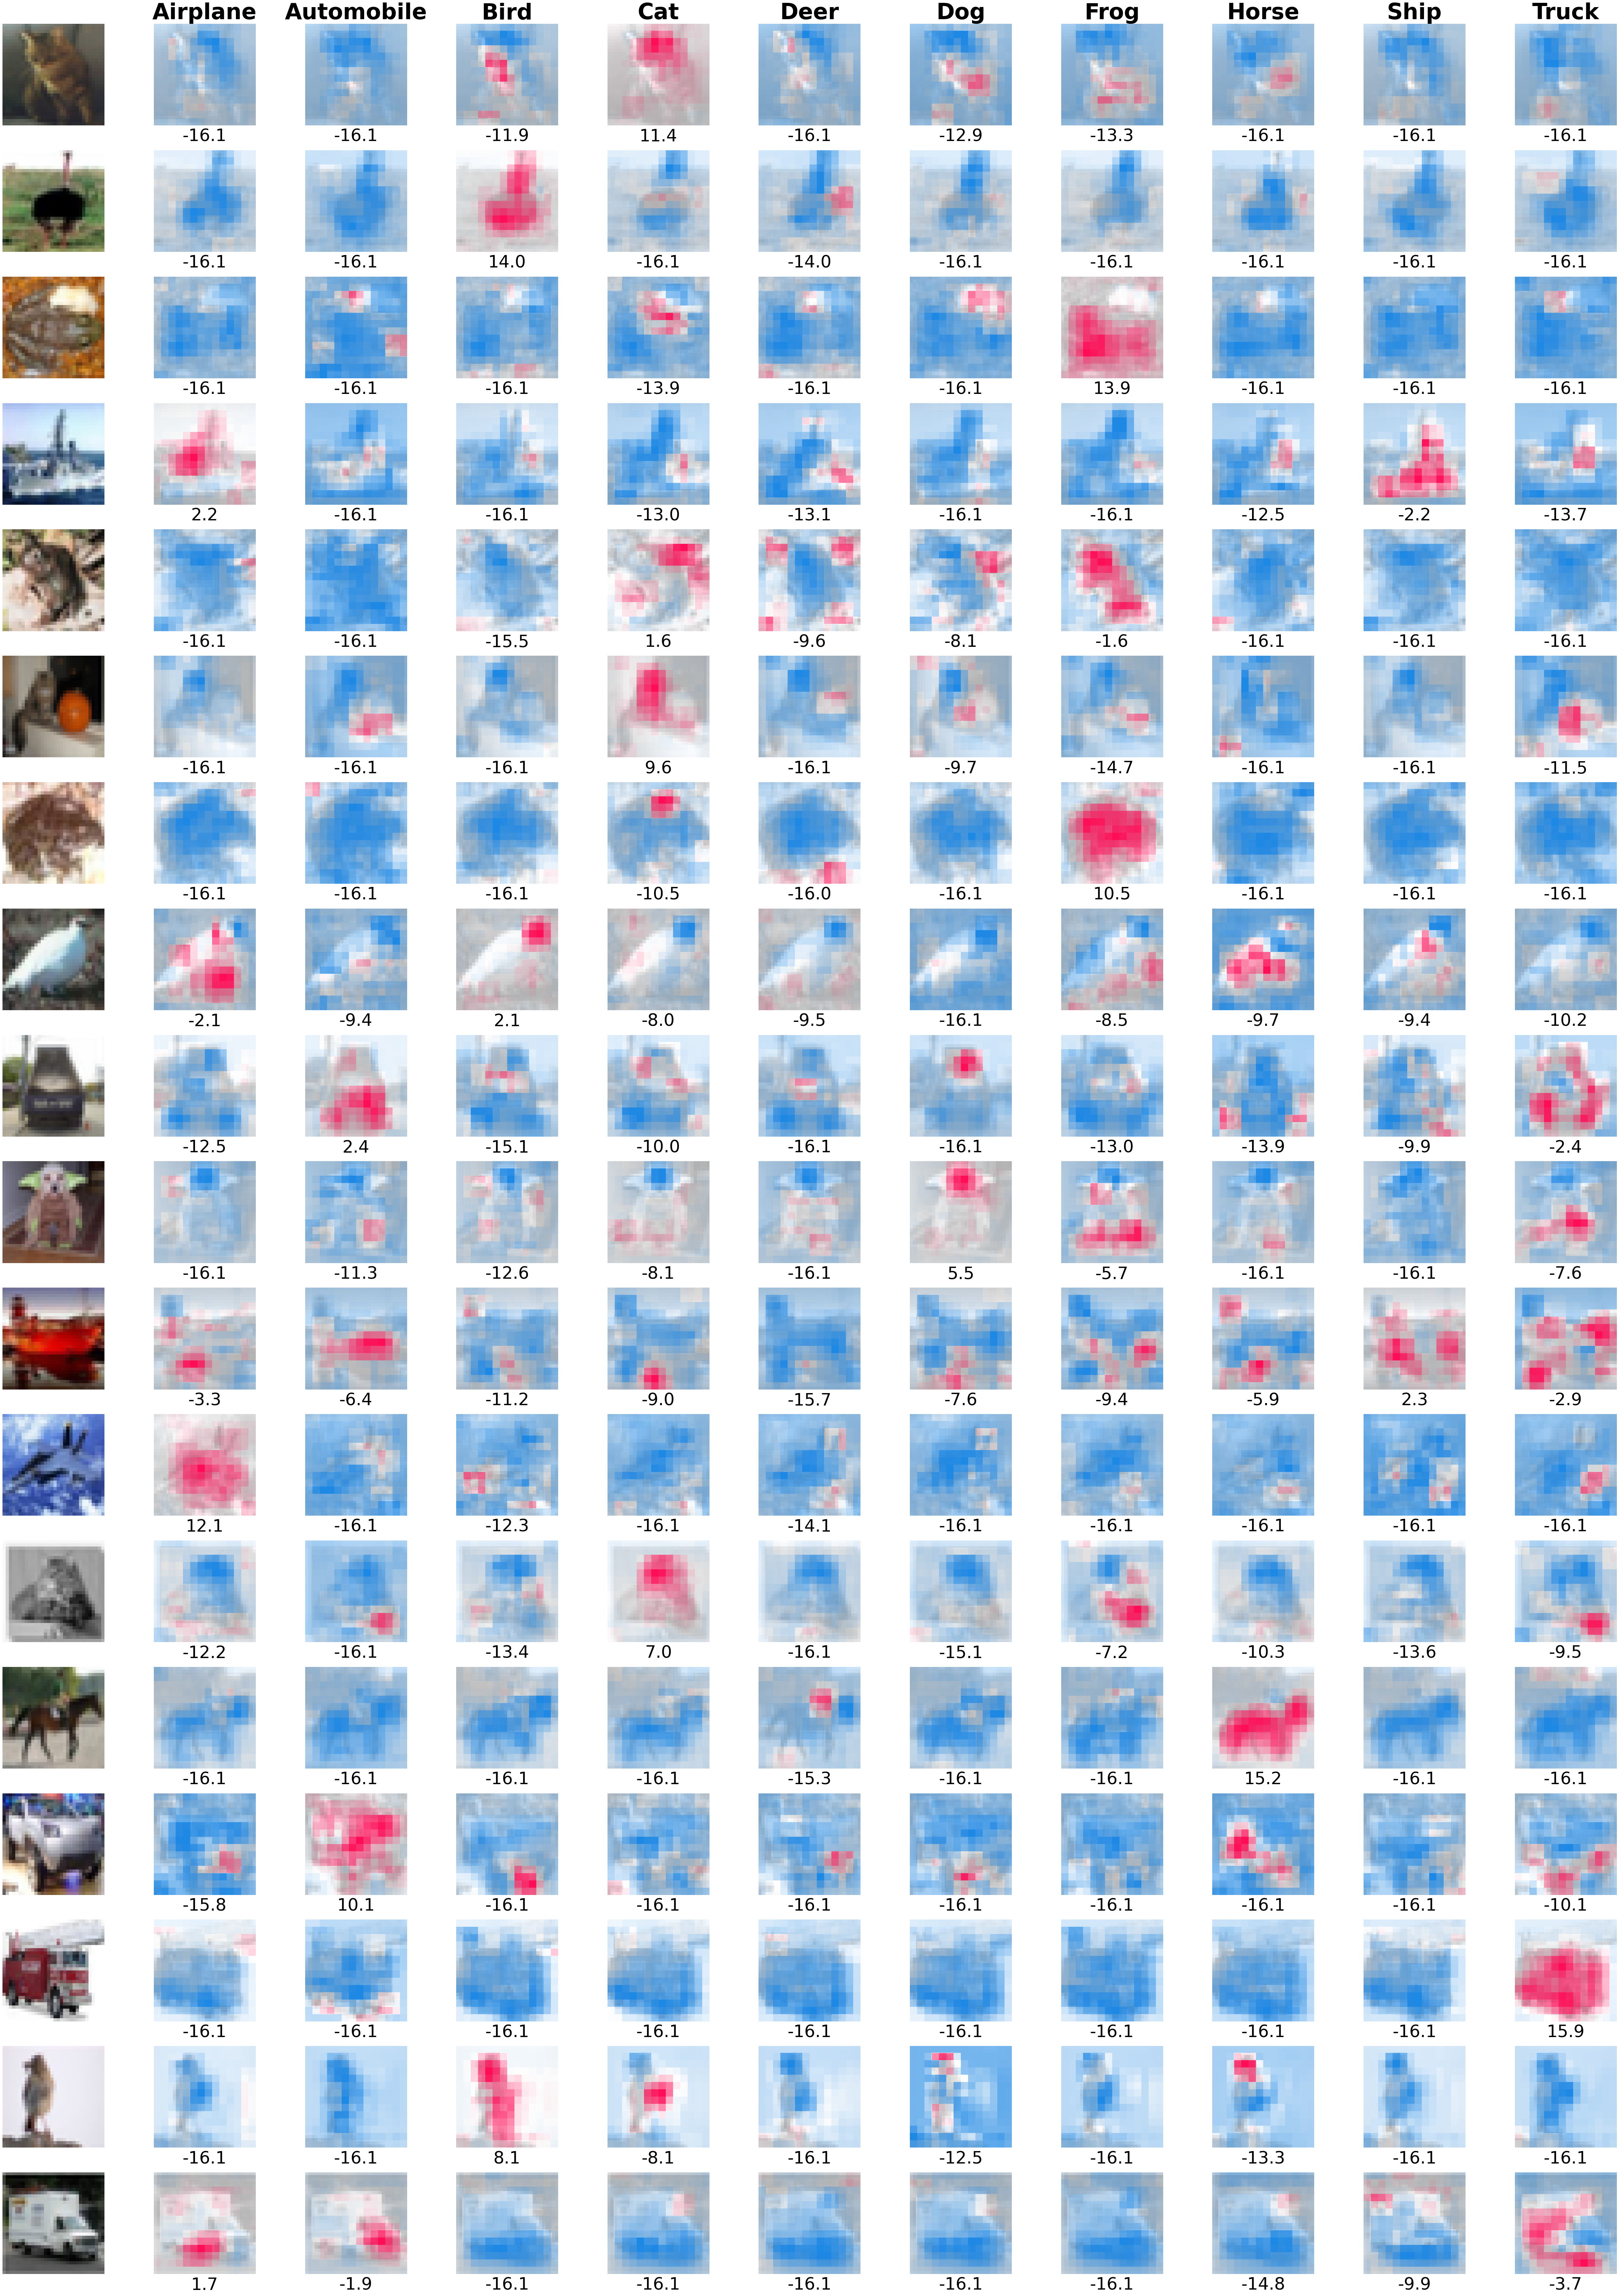

In [16]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.backends.backend_pdf import PdfPages

### Plot
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
n_classes = len(shap_values)
n_images = len(images)
fig_size = np.array([6 * (n_classes + 1), 5 * n_images])
fig, axes = plt.subplots(nrows=n_images, 
                         ncols=n_classes + 1, 
                         figsize=fig_size)
for row in range(len(images)):
    im = images[row]
    
    # get a grayscale version of the image
    if im.max() > 1:
        im /= 255.
    if len(im.shape) == 3 and im.shape[2] == 3:
        im_gray = (0.2989 * im[:,:,0] + 0.5870 * im[:,:,1] + 0.1140 * im[:,:,2]) # rgb to gray
        im_disp = im
    elif len(im.shape) == 3:
        im_gray = im.mean(2)
        # for non-RGB multi-channel data we show an RGB image where each of the three channels is a scaled k-mean center
        flat_vals = im.reshape([im.shape[0]*im.shape[1], im.shape[2]]).T
        flat_vals = (flat_vals.T - flat_vals.mean(1)).T
        means = kmeans(flat_vals, 3, round_values=False).data.T.reshape([im.shape[0], im.shape[1], 3])
        im_disp = (means - np.percentile(means, 0.5, (0,1))) / (np.percentile(means, 99.5, (0,1)) - np.percentile(means, 1, (0,1)))
        im_disp[im_disp > 1] = 1
        im_disp[im_disp < 0] = 0
    else:
        im_gray = im
        im_disp = im
        
    axes[row,0].imshow(im_disp, cmap=plt.get_cmap('gray'))
    axes[row,0].axis('off')
    
    for i, sv in enumerate(shap_values):
        ex = sv[row]
        
        #Get Max Val for color range
        abs_vals = np.abs(ex).flatten()
        max_val = np.max(abs_vals) + 1e-7
        y = preds[row][i]
        
        # Title
        if row == 0:
            axes[row,i+1].set_title('{}'.format(class_names[i]), fontsize=62)
        axes[row,i+1].set_xlabel('{:.1f}'.format(y), fontsize=48)
        
        #Plot
        axes[row,i+1].imshow(im_gray, cmap=plt.get_cmap('gray'), alpha=0.3, extent=(-1, ex.shape[1], ex.shape[0], -1))
        im = axes[row,i+1].imshow(ex, cmap=shap.plots.colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
        
        #Remove Axis
        axes[row,i+1].set_yticklabels([])
        axes[row,i+1].set_xticklabels([])
        axes[row,i+1].set_frame_on(False)
        axes[row,i+1].tick_params(length=0)
 
        
#Figure args
fig.tight_layout()

pdf = PdfPages(os.path.join('results', 'fastshap_cifar10.pdf'))
pdf.savefig(pad_inches=0, bbox_inches='tight')
pdf.close()

plt.show()